# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [1]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

---
### 1 Dataset (6 pts)
#### Data Processing

In [3]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

hypo_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))
prem_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))

hypo_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))
prem_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [4]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
    word_counts = {}
    for sentence in hypo_tokens + prem_tokens:
        for word in sentence:
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
    
    word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))
    id2token = ['<unk>', '<pad>'] + list(word_counts.keys())[:max_vocab_size]
    
    token2id = {}
    for token in id2token:
        token2id[token] = id2token.index(token)

    return token2id, id2token

**Coding 2: finish `token2index` function** (2 pts)

In [5]:
def token2index(tokens_data):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    indices_data = [[token2id[token] if token in id2token else UNK_IDX for token in sentence] for sentence in tokens_data]

    return indices_data


In [6]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
hypo_data_indices_train = token2index(hypo_data_tokens_train)
prem_data_indices_train = token2index(prem_data_tokens_train)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)  

#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [7]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=PAD_IDX)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=PAD_IDX)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [8]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [9]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). (8 pts)

In [10]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO: 
        self.reduce = reduce
        self.input_dim = emb_dim
        self.emb_dim = emb_dim
        # 1. Embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_IDX)
        # 2. Linear Layers
        self.model = nn.Sequential(
            nn.Linear(self.emb_dim, n_out),
            nn.Softmax(dim=1)
        )
        
        

    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
            @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_hypo.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in data_prem.
            """
        
        # TODO:
        # word embedding
        # combine to sentence
        hypo_sentence_embeddings = torch.sum(self.embedding(data_hypo), dim=1) / length_hypo.unsqueeze(1)
        prem_sentence_embeddings = torch.sum(self.embedding(data_prem), dim=1) / length_prem.unsqueeze(1)

        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)
        if self.reduce == 'concat':
            input = torch.cat([hypo_sentence_embeddings, prem_sentence_embeddings], dim=1)
            self.input_dim *= 2
        if self.reduce == 'sum':
            input = hypo_sentence_embeddings + prem_sentence_embeddings
        if self.reduce == 'hadamard':
            input = hypo_sentence_embeddings * prem_sentence_embeddings
        
        # hidden layers 
        out = self.model(input)

        return out

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 


In [11]:
# Hyper paramter example

# 1. size of vocab 
max_vocab_size = 10000
# 2. embedding dimension
emb_dim = 50
# 3. reduce : ["sum", "hadamard", "concat"]
reduce = "hadamard"
# 4. learning_rate
learning_rate = 0.01

# you can change other configuration, e.g. SGD vs Adam, weight decay, dropout

# training parameters
num_epochs = 10 
BATCH_SIZE = 1024


**Coding 5: finish training and validation** (4 pts)

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=newsgroup_collate_func)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=newsgroup_collate_func)

In [13]:
# training:
def init_model(hparams, n_classes=3):
    vocab_size = hparams['max_vocab_size']
    embed_dim = hparams['emb_dim']
    reduce = hparams['reduce']
    learning_rate = hparams['learning_rate']
    
    model = LogisticsModelPytorch(vocab_size, emb_dim, n_classes, reduce)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return model, criterion, optimizer 

def accuracy(preds, trues):
    matches = preds == trues
    return matches.sum().item() / len(trues)

def train(model, optimizer, criterion):
    epoch_stats = {
        'train_losses': [], # record training loss after every epoch
        'val_losses': [], # record validation loss after every epoch
        'train_accs': [], # record training accuracy after every epoch
        'val_accs': [], # record validation accuracy after every epoch
    }
    batch_stats = {
        'train_losses_batch': [], # record training loss after every batch
        'train_accs_batch': [], # record training accuracy after every batch
    }
    
    for epoch in tqdm(range(num_epochs), desc=f'epoch'):
        train_losses_sub = []
        train_accs_sub = []
        
        for data_hypo_train, length_hypo_train, data_prem_train, length_prem_train, labels_train in train_loader:
            optimizer.zero_grad()
            train_outputs = model.forward(data_hypo_train, length_hypo_train, data_prem_train, length_prem_train)
            train_loss = criterion(train_outputs, labels_train)
            train_preds = torch.argmax(train_outputs, dim=1)
            
            train_loss.backward()
            optimizer.step()
            
            train_losses_sub.append(train_loss.item())
            train_accs_sub.append(accuracy(train_preds, labels_train))

        batch_stats['train_losses_batch'] += train_losses_sub
        batch_stats['train_accs_batch'] += train_accs_sub

        epoch_stats['train_losses'].append(np.mean(train_losses_sub))
        epoch_stats['train_accs'].append(np.mean(train_accs_sub))

        with torch.no_grad():
            for data_hypo_val, length_hypo_val, data_prem_val, length_prem_val, labels_val in val_loader:
                val_outputs = model.forward(data_hypo_val, length_hypo_val, data_prem_val, length_prem_val)
                val_loss = criterion(val_outputs, labels_val)
                val_preds = torch.argmax(val_outputs, dim=1)

        epoch_stats['val_losses'].append(val_loss.item())
        epoch_stats['val_accs'].append(accuracy(val_preds, labels_val))
    
    return epoch_stats, batch_stats, {'val_preds': val_preds, 'val_labels': labels_val}
    

In [14]:
emb_dims = [10, 50, 100, 400]
reduces = ['hadamard', 'sum']

experiments = []
for emb_dim in emb_dims:
    for reduce in reduces:
        experiment = {
            'max_vocab_size': len(id2token),
            'emb_dim': emb_dim,
            'reduce': reduce,
            'learning_rate': 0.01
        }
        model, criterion, optimizer = init_model(hparams=experiment, n_classes=len(set(label_index_train)))
        epoch_stats, batch_stats, val_data_preds = train(model, optimizer, criterion)
        experiment['epoch_stats'] = epoch_stats
        experiment['batch_stats'] = batch_stats
        experiment['val_data_preds'] = val_data_preds
        experiments.append(experiment)



epoch: 100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


In [15]:
print('Validation accuracies')
for i in range(len(experiments)):
    print('emb_dim {} and {} reduce: {}'.format(experiments[i]['emb_dim'], experiments[i]['reduce'], experiments[i]['epoch_stats']['val_accs']))

Validation accuracies
emb_dim 10 and hadamard reduce: [0.45, 0.556, 0.575, 0.595, 0.601, 0.602, 0.602, 0.609, 0.611, 0.608]
emb_dim 10 and sum reduce: [0.477, 0.544, 0.569, 0.564, 0.566, 0.574, 0.573, 0.582, 0.57, 0.571]
emb_dim 50 and hadamard reduce: [0.548, 0.599, 0.628, 0.633, 0.643, 0.643, 0.635, 0.642, 0.637, 0.637]
emb_dim 50 and sum reduce: [0.557, 0.593, 0.587, 0.581, 0.578, 0.574, 0.574, 0.575, 0.574, 0.585]
emb_dim 100 and hadamard reduce: [0.548, 0.618, 0.626, 0.628, 0.614, 0.613, 0.618, 0.632, 0.629, 0.625]
emb_dim 100 and sum reduce: [0.563, 0.581, 0.585, 0.577, 0.589, 0.586, 0.586, 0.579, 0.579, 0.573]
emb_dim 400 and hadamard reduce: [0.616, 0.63, 0.643, 0.632, 0.626, 0.629, 0.622, 0.625, 0.627, 0.625]
emb_dim 400 and sum reduce: [0.562, 0.579, 0.577, 0.573, 0.562, 0.565, 0.563, 0.568, 0.568, 0.566]


#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
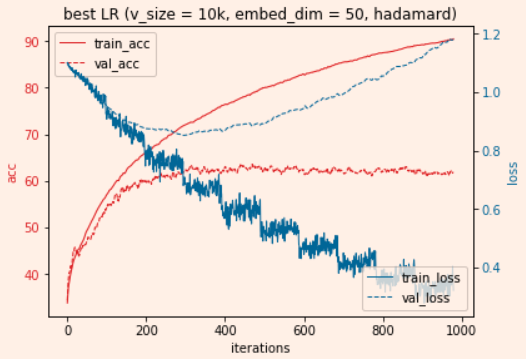

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

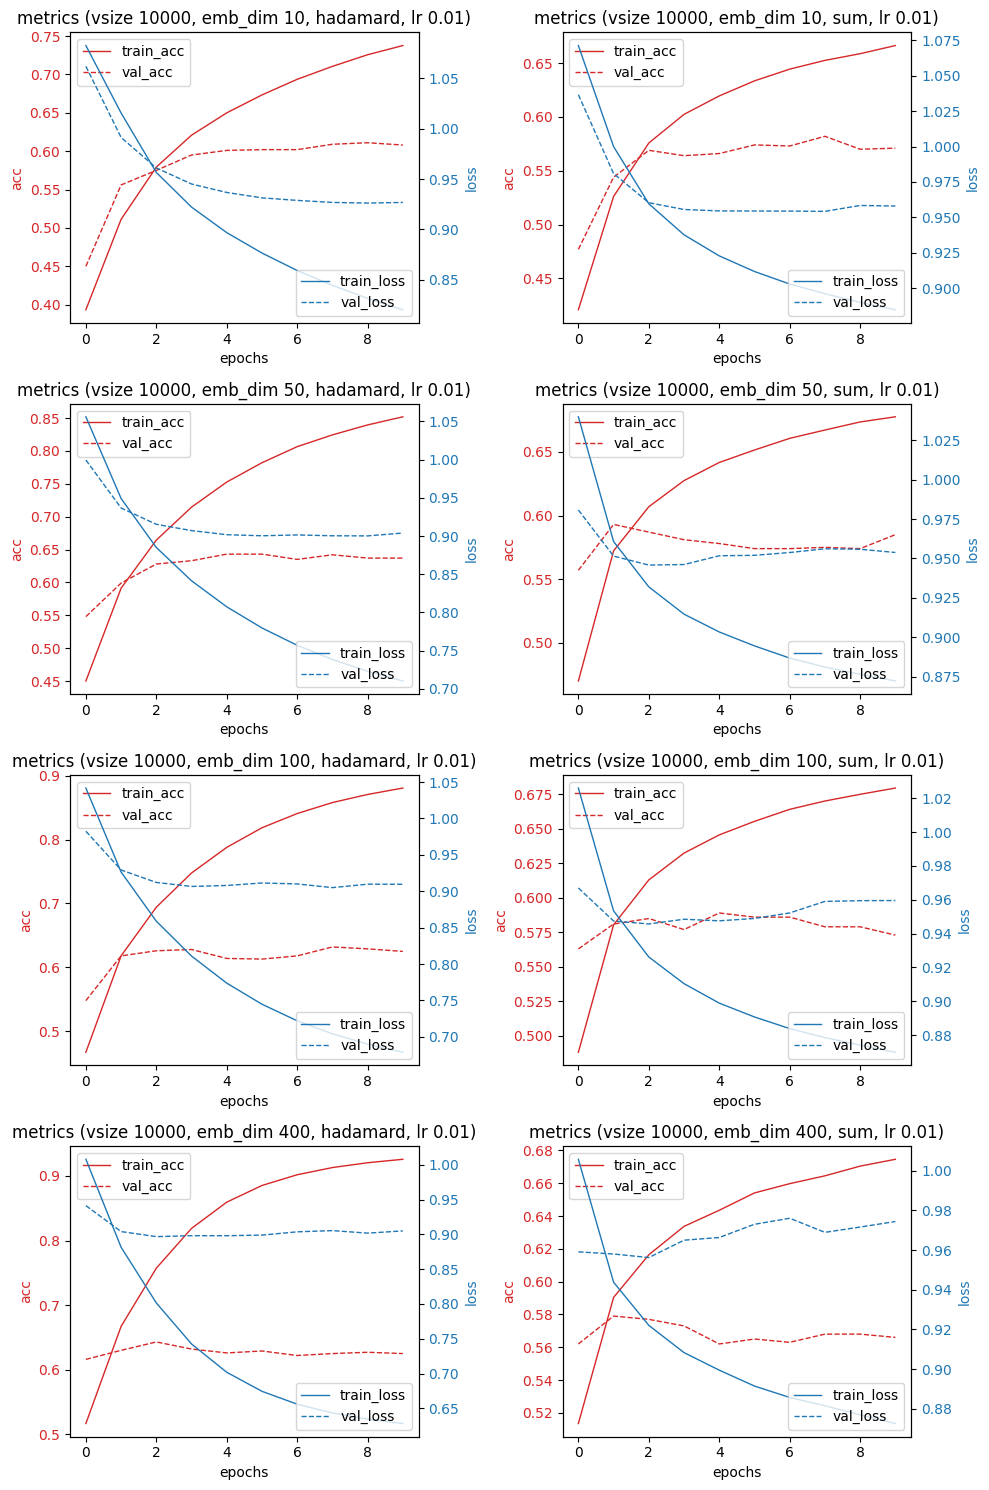

In [16]:
import math
def plot_over_training(experiments):
  """Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  

  fig, axs = plt.subplots(math.ceil(len(experiments)/2), 2, figsize=[10, 15])

  for i in range(len(experiments)):
    per_epoch_metrics = experiments[i]['epoch_stats']
    title_name = 'metrics (vsize {}, emb_dim {}, {}, lr {})'.format(experiments[i]['max_vocab_size']-2, 
                                                                          experiments[i]['emb_dim'],
                                                                          experiments[i]['reduce'],
                                                                          experiments[i]['learning_rate'])

    t = np.arange(0, len(per_epoch_metrics['train_accs']))
    train_acc = per_epoch_metrics['train_accs']
    val_acc = per_epoch_metrics['val_accs']
    train_loss = per_epoch_metrics['train_losses']
    val_loss = per_epoch_metrics['val_losses']

    row, col = i // 2, i % 2    
    ax1 = axs[row, col]
    ax1.set_title(title_name)

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('acc', color=color)
    ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
    ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
    ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='lower right')
    fig.tight_layout() 
    
  plt.show()

plot_over_training(experiments)

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

In [17]:
best_exp = experiments[0]
best_exp_num = 0
for i in range(len(experiments)):
    if np.max(experiments[i]['epoch_stats']['val_accs']) > np.max(best_exp['epoch_stats']['val_accs']):
        best_exp = experiments[i]
        best_exp_num = i

print('Best Experiment (Based on max val accuracy achieved at any point during training):')
print('Experiment {}: (vsize {}, emb_dim {}, {}, lr {})'.format(best_exp_num,
                                                                best_exp['max_vocab_size']-2, 
                                                                best_exp['emb_dim'],
                                                                best_exp['reduce'],
                                                                best_exp['learning_rate']))
print('Top Validation Accuracy: {}'.format(np.max(best_exp['epoch_stats']['val_accs'])))

Best Experiment (Based on max val accuracy achieved at any point during training):
Experiment 2: (vsize 10000, emb_dim 50, hadamard, lr 0.01)
Top Validation Accuracy: 0.643


**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

In [18]:
val_labels = best_exp['val_data_preds']['val_labels']
val_preds = best_exp['val_data_preds']['val_preds']
pred_label_compare = (best_exp['val_data_preds']['val_preds'] == best_exp['val_data_preds']['val_labels'])
label_dict = {0: 'neutral', 1: 'entailment', 2: 'contradiction'}

wrong_pred_idxs = []
for idx in range(len(pred_label_compare)):
    if pred_label_compare[idx] == False:
        wrong_pred_idxs.append(idx)

for i in wrong_pred_idxs[5:8]:
    print(f'Premise {i}:')
    print(prem_data_tokens_val[i])
    print(f'Hypothesis {i}:')
    print(hypo_data_tokens_val[i])
    print(f'Pair {i} Label: {label_dict[int(val_labels[i])]} Pred: {label_dict[int(val_preds[i])]}')

Premise 20:
['a', 'woman', 'is', 'sitting', 'in', 'a', 'street', 'market', 'stand', 'where', 'there', 'are', 'various', 'items', 'for', 'sale', 'such', 'as', 'fish']
Hypothesis 20:
['the', 'woman', 'is', 'in', 'a', 'street', 'market']
Pair 20 Label: entailment Pred: neutral
Premise 21:
['a', 'group', 'of', 'people', 'are', 'sitting', 'under', 'umbrellas', 'on', 'the', 'beach']
Hypothesis 21:
['it', 'is', 'a', 'saturday']
Pair 21 Label: neutral Pred: contradiction
Premise 23:
['people', 'walk', 'amongst', 'a', 'traffic', 'jam', 'in', 'a', 'crowded', 'city']
Hypothesis 23:
['the', 'traffic', 'is', 'halted', 'and', 'people', 'are', 'walking', 'between', 'the', 'cars']
Pair 23 Label: entailment Pred: contradiction


**Premise / hypothesis 20:** The details of the woman being in the street market may have been washed out by the rich additional information in the hypothesis about items for sale in the market, such that the model was unable to conclude that the hypothesis was sufficiently similar to the premise.

**Premise / hypothesis 21:** It's possible that the model locates contradictions by comparing the use of singular vs. plural subjects in the premise / hypothesis. Since the premise uses singular "it is" while the hypothesis uses plural "group of people are", the model may have interpreted this as a signal for contradiction.

**Premise / hypothesis 23:** We see the word "halted" appear in the hypothesis, which may have contributed to the incorrect "contradiction" label since the premise talks about people walking.